# Mooring Synthesis of Initial NC data (offline)

## 19CKP1A

- from netcdf files
- plot all depths of each parameter on each other for comparative purposes
- Temperature, Salinity, Pressure in this notebook.  See companion for Oxygen, Chlor, ADCP/currents, etc

In [ ]:
import xarray as xa
import pandas as pd
import numpy as np
import cmocean

%matplotlib inline
import matplotlib.pyplot as plt

In [5]:
ncfiles = '/Users/bell/ecoraid/2019/Moorings/19ckp1a/final_data_cf/19ckp1a_*_*.nc'

mfd = xa.open_mfdataset(ncfiles, compat='override')
mfd

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

## Temperature (full temporal resolution)

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


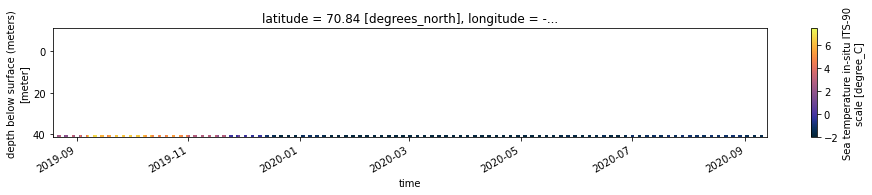

In [4]:
upper_temp = mfd.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=upper_temp,cmap=cmocean.cm.thermal)

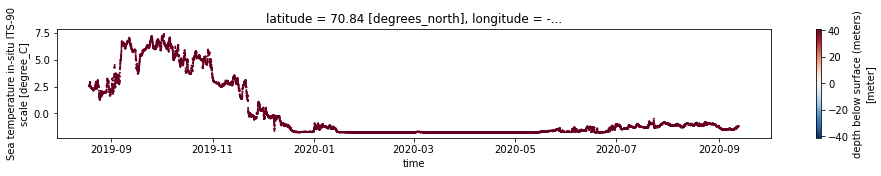

In [5]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.isel(latitude=0,longitude=0).plot.scatter(x="time",y="temperature",hue="depth",s=1,ax=ax)

**Note:** not everything has constant sample frequencies so if nan's are in the mix, then lineplots are less useful (see plot below)
Will want to resample to hourly or daily to evaluate those

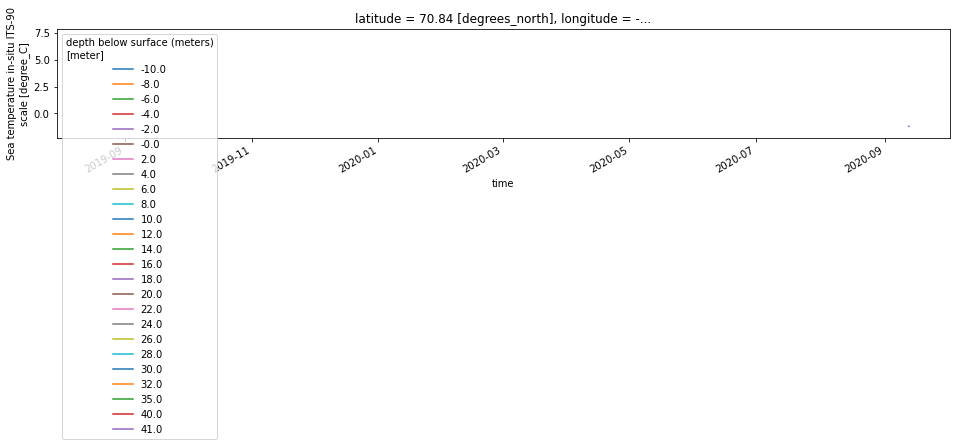

In [6]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.temperature.isel(latitude=0,longitude=0).plot.line(x="time",hue="depth",ax=ax);

## Salinity(full temporal resolution)

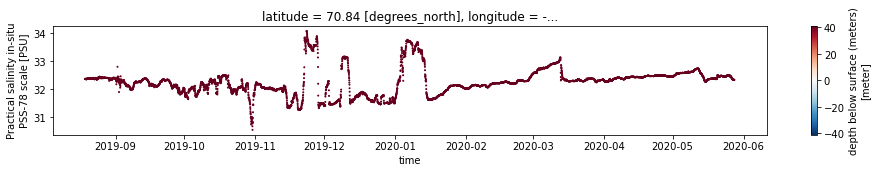

In [7]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.isel(latitude=0,longitude=0).plot.scatter(x="time",y="salinity",hue="depth",s=1,ax=ax)

## Pressure (full temporal resolution)

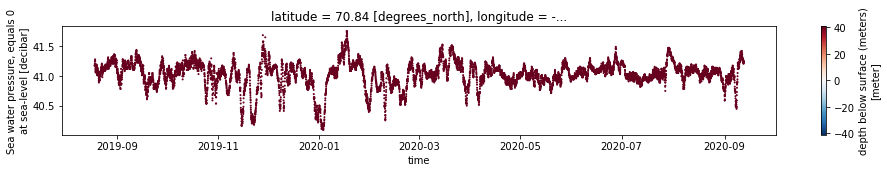

In [8]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd.isel(latitude=0,longitude=0).plot.scatter(x="time",y="pressure",hue="depth",s=1,ax=ax)

## Hourly/Interpolated plots Plots

Because of the different timebases... quickly either interpolate (linearly) or downsample (this seems slower) to plot all series

In [9]:
# mfd_hourly = mfd.resample(time='1H').median() #not fast
mfd_up = mfd.interpolate_na("time")

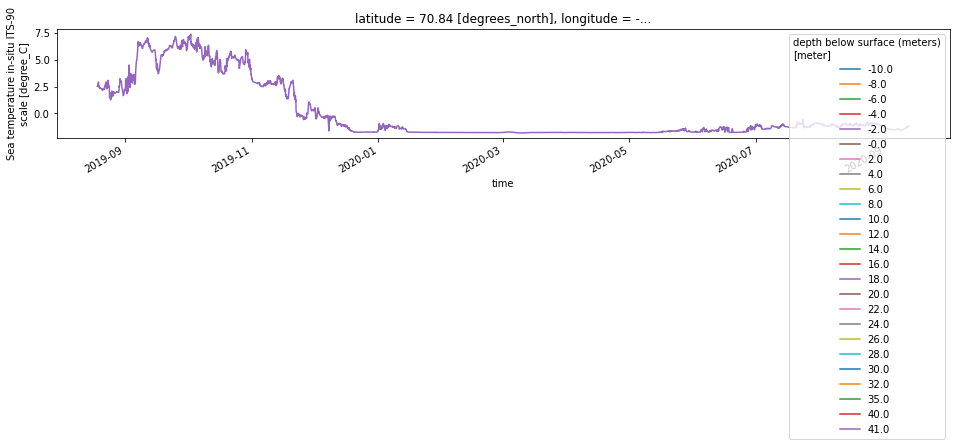

In [10]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.temperature.plot(x="time",hue="depth",ax=ax);

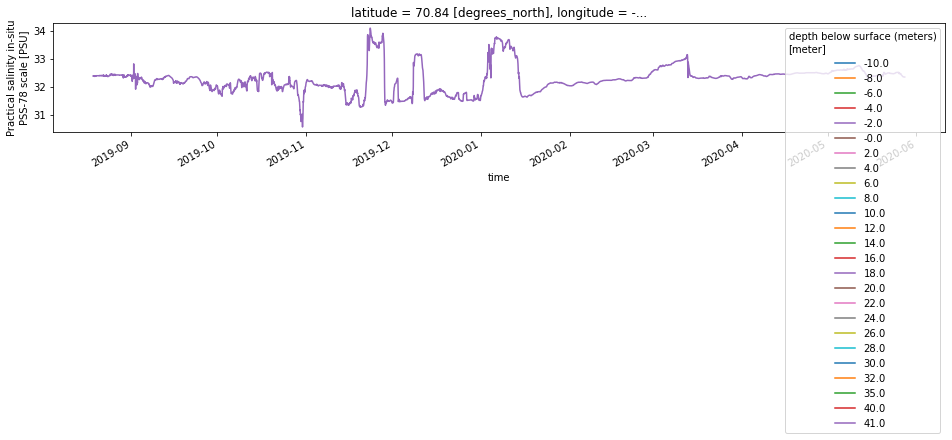

In [11]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.salinity.plot(x="time",hue="depth",ax=ax);

/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/dask/utils.py:37: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)
/Users/bell/miniconda3/envs/py38/lib/python3.8/site-packages/dask/core.py:119: RuntimeWarning: All-NaN slice encountered
  return func(*(_execute_task(a, cache) for a in args))


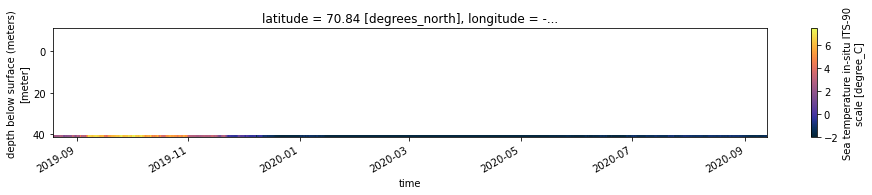

In [12]:
upper_temp = mfd_up.temperature.max(axis=0).max(axis=0).values
lower_temp = -2

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.temperature.T.plot(ax=ax,yincrease=False,vmin=lower_temp,vmax=upper_temp,cmap=cmocean.cm.thermal)

## Chlorophyll Hourly Interpolated Plots

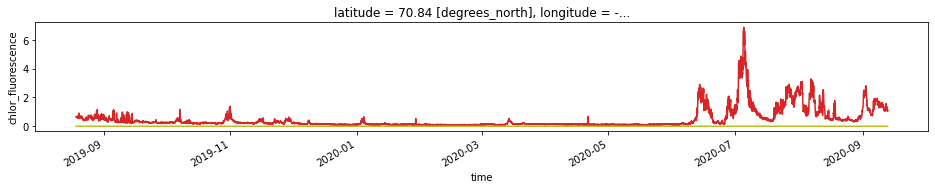

In [13]:
fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.plot(x="time",hue="depth",ax=ax,add_legend=False);
(mfd_up.chlor_fluorescence*0).plot(x="time",hue="depth",ax=ax,add_legend=False);

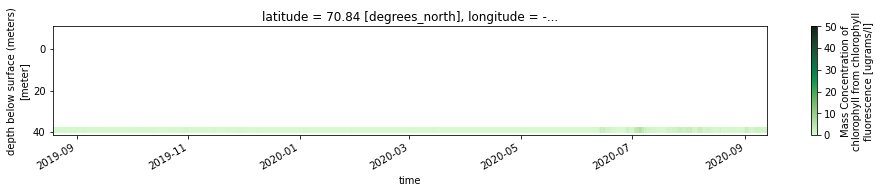

In [14]:
upper = 50
lower = 0

fig, ax = plt.subplots(1,figsize=(16, 2))
mfd_up.chlor_fluorescence.T.plot(ax=ax,yincrease=False,vmin=lower,vmax=upper,cmap=cmocean.cm.algae)

## Compare Timeseries to CTD Casts

CTD: DY1908 CTD003 is 1.0002747615881 km away ***  
CTD: DY1908 CTD004 is 1.0002747615881 km away  
CTD: DY2012 CTD071 is 0.86362049255804 km away ***   
CTD: DY2103 CTD006 is 2.7703084763244 km away ***  
CTD: DY2103 CTD007 is 2.1568009880113 km away ***   

- Recovery CTDXXX on DY2103 (wont be useful for much due to length of deployment)


In [15]:
import EcoFOCIpy.io.erddap as erddap

In [16]:
url = "http://akutan.pmel.noaa.gov:8080/erddap"

erddap.test_erddap_connection(url=url) #basic test for connection to internal server, no response is a good thing

In [17]:
#grap deploy/recover cast data from erddap hosted sets - you have to know which profile you want though
depcast = erddap.erddapCTDretrieve(url=url,cruiseid='os1901l1',qclevel='final',concastno='030')
reccast = erddap.erddapCTDretrieve(url=url,cruiseid='dy2012',qclevel='preliminary',concastno='047')

<div class="alert alert-block alert-warning">
<b>User Alert:</b> Update deployment specific notes below.

## QC Notes


(PJS needs to vet these)

## Generate to_edit files for PJS

- these are usually salinity focused and need the ctd casts as well as the salinity timeseries.
- save the native time scale, not the interpolated or upscaled version

In [ ]:
with pd.ExcelWriter('19bs2c_salinity_to_edit.xlsx') as writer:  

    for depthkey in mfd.to_dataframe().salinity.groupby(level=[0]).groups.keys():
        if not (mfd.to_dataframe().salinity.groupby(level=[0]).get_group(depthkey).dropna(how='all')).empty:
            print(f'saving {depthkey}')
            (mfd.to_dataframe().salinity.groupby(level=[0]).get_group(depthkey).dropna(axis=0)).to_excel(writer, sheet_name=str(depthkey))

    depcast.to_excel(writer, sheet_name=depcast.profile_id.unique()[0])
    reccast.to_excel(writer, sheet_name=reccast.profile_id.unique()[0])